In [29]:
using LinearAlgebra, Statistics
using Distributions, Expectations, LaTeXStrings,NLsolve, Plots, PlotThemes

In [30]:
#Simulation global parameters
utility_type = 1; # 0: Linear, 1: CRRA
wage_distribution_samples = 600;   # Number of samples for the wage distribution and wage grid points

In [31]:
function solve_mccall_model(mcm; utility_type = 0, U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; alpha, beta, sigma, c, gamma, w, dist, u) = mcm

    # parameter validation
    @assert c > 0.0
    @assert minimum(w) > 0.0 # perhaps not strictly necessary, but useful here

    # necessary objects
    # Define utility function based on utility_type switch
    if utility_type == 0
        # Linear utility
        u_w = mcm.u.(w)
        u_c = mcm.u(c)
    elseif utility_type == 1
        # CRRA utility
        u_w = mcm.u.(w, sigma)
        u_c = mcm.u(c, sigma)
    else
        throw(ArgumentError("Invalid utility_type: must be 0 (linear) or 1 (CRRA)"))
    end

    E = expectation(dist) # expectation operator for wage distribution

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:(end - 1)]
        U = x[end]
        [u_w + beta * ((1 - alpha) * V .+ alpha * U);
         u_c + beta * (1 - gamma) * U + beta * gamma * E * max.(U, V)]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:(end - 1)]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w_bar = Inf
    else
        w_bar = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (; V, U, w_bar)
end

solve_mccall_model (generic function with 1 method)

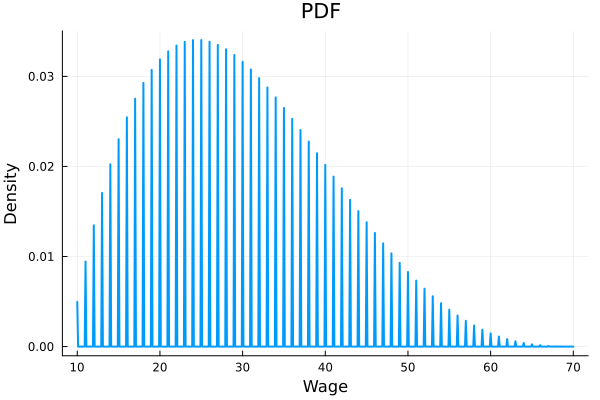

In [32]:
# Define a LogNormal distribution
#dist = LogNormal(3.5, 0.5)
dist = BetaBinomial(59, 2, 4)+10

# Define a range of wage values
wage_values = 10:0.1:70

# Get the PDF for each wage value
pdf_values = pdf.(dist, wage_values)

# Plot the PDF
plot(wage_values, pdf_values, 
    lw = 2, title = "PDF ", 
    xlabel = "Wage", ylabel = "Density", 
    legend = false, grid = true)

In [33]:
expectation(dist)

IterableExpectation{StepRangeLen{Int64, Int64, Int64, Int64}, Vector{Float64}}(10:1:69, [0.00496031746031746, 0.009440604198668733, 0.01346446828334717, 0.017054993158906406, 0.020234737646160083, 0.02302573594218222, 0.025449497620306703, 0.027527007630127717, 0.029278726297499346, 0.03072458932453648  …  0.0014715695902898524, 0.0011253179219863501, 0.0008341517463675036, 0.0005949233209941799, 0.00040396027968740895, 0.00025706563252835115, 0.00014951776585832573, 7.607044227879713e-5, 3.095280065137283e-5, 7.869356097806633e-6])

In [34]:
function McCallModel(; alpha = 0.2,
    beta = 0.98, # discount rate
    gamma = 0.7,
    c = 6.0, # unemployment compensation
    sigma = 2.0,
    utility_type = 0,  # 0 for linear utility, 1 for CRRA utility
    w = range(10, 70, length = wage_distribution_samples), # wage values
    dist = BetaBinomial(wage_distribution_samples-1 , 2, 4))+10 # distribution over wage values

    # Define utility function based on utility_type switch
    if utility_type == 0
        # Linear utility
        u = c -> c
    elseif utility_type == 1
        # CRRA utility
        u = (c, sigma) -> (c^(1 - sigma) - 1) / (1 - sigma)
    else
        throw(ArgumentError("Invalid utility_type: must be 0 (linear) or 1 (CRRA)"))
    end
    
    return (; alpha, beta, gamma, c, sigma, u, w, dist)
end

McCallModel (generic function with 1 method)

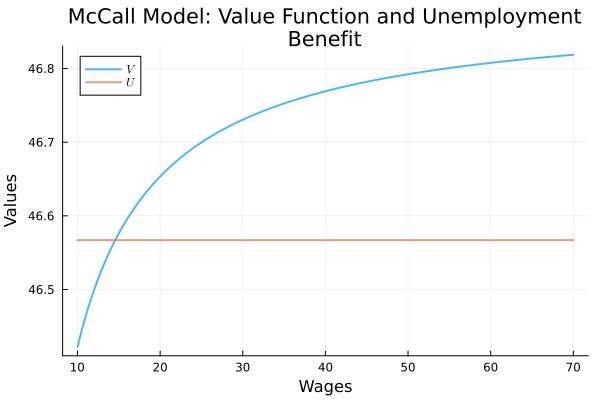

In [35]:
mcm = McCallModel(; utility_type = utility_type)
(; V, U) = solve_mccall_model(mcm; utility_type = utility_type)
U_vec = fill(U, length(mcm.w))

# Plot 
plot(
    mcm.w, [V U_vec],
    lw = 2, alpha = .7,
    label = [L"V" L"U"],
    title = "McCall Model: Value Function and Unemployment\nBenefit",
    xlabel = "Wages", ylabel = "Values",
    legend = :topleft,
    grid = true,
)

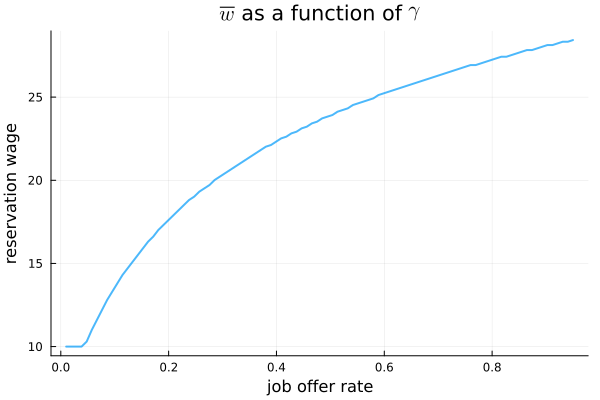

In [36]:
gamma_vals = range(0.01, 0.95, length = 100)

models = [McCallModel(gamma = gammaval) for gammaval in gamma_vals]
sols = solve_mccall_model.(models)
w_bar_vals = [sol.w_bar for sol in sols]

plot(gamma_vals, w_bar_vals, lw = 2, alpha = 0.7, 
     xlabel = "job offer rate",
     ylabel = "reservation wage",
     label = false,
     title = L"$\overline{w}$ as a function of $\gamma$")

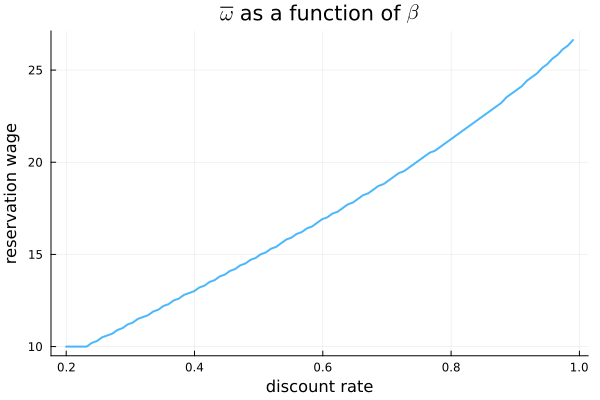

In [37]:
beta_vals = range(0.2, 0.99, length = 100)

models = [McCallModel(beta = betaval) for betaval in beta_vals]
sols = solve_mccall_model.(models)
w_bar_vals = [sol.w_bar for sol in sols]

plot(beta_vals, w_bar_vals, lw = 2, alpha = 0.7, 
     xlabel = "discount rate",
     ylabel = "reservation wage",
     label = false,
     title = L"$\overline{\omega}$ as a function of $\beta$")